In [1223]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from pdb import set_trace
import glob
from collections import Counter
from IPython.display import HTML

In [193]:
### ADD PLAYER STATS DF

player_stats_file = 'library/Blueprint 2019 Players.csv'
player_stats_df = pd.read_csv(player_stats_file)

#change all columns to numeric
column_list = ['Total completed throw distance (m)','Total completed throw gain (m)',
                 'Total caught pass distance (m)']

for i in column_list:
    player_stats_df[i] = [x.replace(',','') for x in player_stats_df[i]]
    player_stats_df[i] = pd.to_numeric(player_stats_df[i])             

#change index to payer name
player_stats_df = player_stats_df.set_index('Player')

#create player inits column
players = list(player_stats_df.index)
player_inits = []
for p in players:
    try:
        player_init = p.split(' ')[0][0] + p.split(' ')[1][0]
    except IndexError:
        player_init = p.split(' ')[0][:2]
    player_inits.append(player_init)
    
player_stats_df['player_inits'] = player_inits

#create a a new position_df to host player names and positions. will merge with player_df later
position_df = pd.DataFrame(columns=['Player','Position'])
position_df['Player'] = list(player_stats_df.index)
#manually enter all positions for players
position_df['Position'] = ['C','C','C','H','C','H','C','C','C','C','H','C','C','H','C','C','H','C','H','H',
                           'C','C','H','C','C','H','C','H']

#create a column for pecent of total points played that are offensive points
player_stats_df['percent_Opp'] = player_stats_df['Offense points played'] / player_stats_df['Points played total']

#assign players as 'offense', 'defense', or 'flex'
#assignment is split into thirds of playing time
#ex: < .33 of total points played on offense = 'defense'
#'flex' is the middle third
player_stats_df['Line'] = ['Off' if x >= .66 else 'def' if x < .33 else 'Flex' 
                           for x in player_stats_df['percent_Opp']]

#set player to index of position_df
position_df = position_df.set_index('Player')

#join position and player stats on the index of player
player_stats_df = player_stats_df.join(position_df)

player_stats_df.reset_index(inplace=True)

# Max Cohen - Ultimate Frisbee Statistics
(I've included the toggle above because there is lots of code used to manipulate data in this notebook)

In [194]:
### COMBINE GAMExGAME POSSESSION DATA INTO ONE POSS_DF

#give file path abbreviation
poss_path_abbr = 'library/possessions/Possessions vs.*.csv'
#create list of files that match the possession convention
file_list = glob.glob(poss_path_abbr)
#create an empty df
poss_df = pd.DataFrame()
#loop through each file in the list
for file in file_list:
    #add an oppnent depending on the name of the file
    opponent = file.split('vs. ')[1].split(' 2019')[0]
    df_ = pd.read_csv(file)
    #add oppenent name column
    df_['opponent'] = opponent
    #append file to the overall poss_df
    poss_df = poss_df.append(df_)

In [195]:
### COMBINE GAMExGAME PASSES DATA INTO ONE PASSES_DF

#give file path abbreviation
passes_path_abbr = 'library/passes/Passes vs.*.csv'
#create list of files that match the passes convention
file_list = glob.glob(passes_path_abbr)
#create an empty df
passes_df = pd.DataFrame()
#loop through each file in the list
for file in file_list:
    #add an oppnent depending on the name of the file
    opponent = file.split('vs. ')[1].split(' 2019')[0]
    df_ = pd.read_csv(file)
    #add oppenent name column
    df_['opponent'] = opponent
    #append file to the overall passes_df
    passes_df = passes_df.append(df_)

#remove all of the empty data with no thrower nor reciever
passes_df = passes_df.dropna(subset=['Thrower', 'Receiver'])

In [196]:
### MERGE THE PASSES_DF WITH THE POSS_DF AND PLAYER_STATS_DF (player info only)

full_poss_df = pd.merge(passes_df,poss_df,how='left',on=['Point','Possession','opponent'],copy=False)
full_poss_df = full_poss_df.reset_index(drop=True)
full_poss_df = full_poss_df.drop(columns=['Created_y','Start X (0 -> 1 = left sideline -> right sideline)_y',
                  'Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)_y'])
full_poss_df.columns = [x.replace('_x','') for x in full_poss_df.columns]
#create a unique posession index based on opponent, point#, possession#
for x in full_poss_df.index:
    full_poss_df.loc[x,'possession_index'] = full_poss_df.loc[x,'opponent'] + ' | ' + \
    str(full_poss_df.loc[x,'Point']) + '.' + \
    str(full_poss_df.loc[x,'Possession'])
#write to CSV
full_poss_df.to_csv('library/possessions/BP_2019_Full_Possession_Data.csv')
#add player info columns for each column that has a name
#list of cols that have a name
name_cols = ['Thrower','Receiver','Initiator','Secondary assist','Assist','Goal','Thrower error',
             'Receiver error']
#for loop to add line and position by merging in player_stats_df
for i in name_cols:
    full_poss_df = (full_poss_df
                     .merge(player_stats_df[['Player','Line','Position']],
                            left_on=i,right_on='Player',how='left')
                     .drop(columns='Player')
                     .rename(columns={'Line':f'{i}_line','Position':f'{i}_position'}))

### Ultimate Frisbee and NYC Blueprint: Introduction
Before Coronavirus, I spent a lot of my time playing and coaching Ultimate Frisbee in NYC. I picked up the sport in undergrad and I've loved playing it ever since! Ultimate is a 7v7 game that combines the running of soccer, jumping of basketball, and the throwing and catching of Football. The offense tries to score a point by throwing the disc between teammates, scoring by catching the disc in the endzone. It's played on a field roughly the same size as an American Football field, just a little narrower.<br><br>
For the past few years (not this year unfortunately), I've played on an adult team called NYC Blueprint. We play competeitvely against other teams in our region and across the United States. Last summer (2019) we filmed some of our games and used that film to retroactively take stats using an app that tracks thrower and receiver locations amongst other things. I'm excited to show you and my team what I've learned from the data!

### Seaborn Data Visualization Library
In order to demonstrate some key principles of Ultimate Frisbee and to learn more about our team, I'm going to be use **seaborn**. Seaborn is a data visualizatin library for Python. Much like some other Python visualiztion libraries, seaborn is built on top of matplotlib, which I'm quite comfortable with and allows for thorough plotting and customization options.<br><br>
Seaborn improves upon matplotlib's visual asthetics and makes it easier to encode variables in multiple ways in one plot. Additionally, there are a couple unique and new visualization techniques in seaborn. Namely, built-in functionality for **lineplot confidence intervals** and **jointplots** which combine multiple types of visualization techniques in one figure.

### AN EXAMPLE ULTIMATE FRISBEE POINT
Before we go any further, this is an example frisbee point. As I said before, ultimate is played with 7 people on each team on the field at the same time. However, ONLY the thrower and receiver are represented in our data. The defense and other players on the field are not present. <br><br>
The disc starts at the bottom of the plot, roughly on the endzone line of the "defending endzone". Blueprint has possession and is trying to score in the "scoring endzone", roughly 70 meters away. The disc zigs and zags up the field as it is passed between players until Owen throws a beautiful long pass (a "huck") to Odie in the scoring endzone for a goal! <br><br>
The colors represent the two main position distinctions in Ultimate. Blue for "cutters" -- they are like receivers in American Football, often gaining distance more by catching the disc than by throwing it. Orange for "handlers" -- the quaterbacks of Ultimate, often taking the more difficult and longer throws. Lastly, sometimes the disc is thrown backwards, but not to worry, that's okay. It's sometimes better to throw it backwards than to make a mistake and throw the disc out of bounds or to the other team, giving them a chance to score. Thrower or receiver mistakes, more generally known as turnovers, are really bad in ultimate!

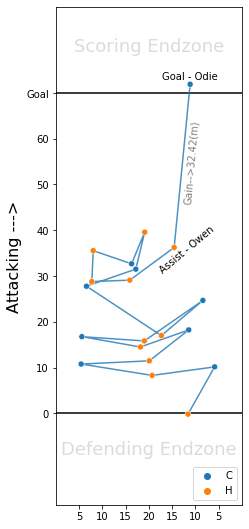

In [1125]:
#Longest successful point
fig, ax = plt.subplots(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()
df = df[ (df['Passes'] == df['Passes'].max()) & (df['Point'] == 18)]

x = (df['Start X (0 -> 1 = left sideline -> right sideline)'].append( 
       pd.Series(df['End X (0 -> 1 = left sideline -> right sideline)'].iloc[-1])))
y = 1 - (df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].append( 
     pd.Series(df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].iloc[-1])))
hue = df['Thrower_position'].append(pd.Series(df['Receiver_position'].iloc[-1]))

grid = sns.lineplot(x=x,y=y,alpha=.8,sort=False,ax=ax,zorder=1)
sns.scatterplot(x=x,y=y,alpha=1,hue=hue,hue_order=['C','H'],zorder=2)

#make field
c = 'k'
grid.axvline(x=0,color=c,alpha=0)
grid.axvline(x=1,color=c,alpha=0)
grid.axhline(y=0,color=c,alpha=0)
grid.axhline(y=.1818181818,color=c,zorder=0)
grid.axhline(y=.8181818181,color=c,zorder=0)
grid.axhline(y=.99,color=c,alpha=0)
grid.margins(x=0,y=0)

#set x and yticks as yard markers every 10 yards
xtick = .25/2
ytick = .181818/2
grid.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
grid.set_xticklabels([5,10,15,20,15,10,5])
grid.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
grid.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

grid.set_xlabel('')
grid.set_ylabel('Attacking --->',fontsize=16)

#annotate endzones
grid.text(.50,.9,'Scoring Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)
grid.text(.50,.1,'Defending Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)

#annotate names
goal = df.iloc[-1]
#goal
grid.text(goal['End X (0 -> 1 = left sideline -> right sideline)'],
          (1-goal['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) + .01,
          'Goal - {}'.format(df.iloc[-1]['Receiver'].split(' ')[0]),
          ha='center')
#assist
grid.text(goal['Start X (0 -> 1 = left sideline -> right sideline)']+.07,
          (1-goal['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) - .05,
          'Assist - {}'.format(df.iloc[-1]['Thrower'].split(' ')[0]),
          ha='center',rotation=40)
#length
grid.text(.73,.6,
          'Gain-->{}(m)'.format(df.iloc[-1]['Forward distance (m)'].round(2)),
          ha='center',rotation=85,color='gray')

ax.legend(loc='lower right')
plt.show()

### PROBABILITY OF SCORING BY VERTICAL POSITION ON THE FIELD
Below, I've plotted our probability of scoring by our vertical position on the field. As we get closer to the scoring endzone, our chances of scoring before we make a mistake (turnover) go up.

In [1238]:
#create bins every two yards
bin_list = []
yardage = 3
for x in range(-3,109,yardage):
    bin_list.append(x + yardage)
    
bins = np.array(bin_list)
#change bins to 0->1 range
bins = [x/110 for x in bins]
#create columns
full_poss_df['y_bucket'] = (pd.cut
                            (full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],
                              bins))
#create hist of all plays
all_hist = np.histogram(1-full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins)
#create his of scored plays
scored_df = full_poss_df[full_poss_df['Scored?'] == 1]
scored_hist = np.histogram(1-scored_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins)

#get bins
all_y = all_hist[0]
scored_y = scored_hist[0]
bins_data = bins[:-1]
#create dict
d = {'all_y':all_y, 'scored_y':scored_y, 'bins':bins_data}
y_score_df = pd.DataFrame(data = d)

#col for conversion rate
y_score_df['conversion_rate'] = y_score_df['scored_y'] / y_score_df['all_y']
#col for yards
y_score_df['yards'] = y_score_df.index * yardage

#remove NAs
y_score_df = y_score_df.dropna()
#create all df so that we can use for expected points added later
y_score_df_all = y_score_df
#final filter to only include number of possessions > 10
y_score_df = y_score_df[y_score_df['all_y'] > 10]

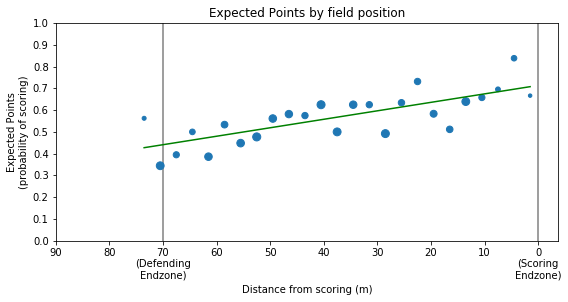

In [1572]:
#by vertical position on the field
#probability of scoring by field position
fig = plt.figure(figsize=(9,4))

x = y_score_df['yards']+(.5*yardage)#<-center the point in the middle of the bin
y = y_score_df['conversion_rate']
s = y_score_df['all_y']
plt.scatter(x,y,s=s)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g",zorder=1)

plt.vlines([20,90],ymin=0,ymax=1,alpha=.5,zorder=0)
plt.margins(y=0)

xtick = 10
ytick = .1

plt.xticks(ticks=[xtick*9,xtick*8,xtick*7,xtick*6,xtick*5,xtick*4,xtick*3,xtick*2,xtick*1,xtick*0],
          labels=[90,80,'70\n(Defending\nEndzone)',60,50,40,30,20,10,'0\n(Scoring\nEndzone)'][::-1])
plt.yticks(ticks=[ytick*0,ytick,ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9,ytick*10])
plt.xlabel('Distance from scoring (m)')
plt.ylabel('Expected Points\n(probability of scoring)')
plt.title('Expected Points by field position')

#plt.grid(which='major', axis='y' ,linestyle='-.', linewidth='.2', color='black')
plt.show()

In [1420]:
#CREATE epa_y
#**this is ONLY in the y direction**
# --- doesn't take into acount assists, receiver epa, turnovers, turnover probability
#take the line function from the above graph
#apply it to each value in forward distance
# --- this alone would give us the epa of the position on the field that equates to that throw distance
#so in order to get the epa that the throw added, we need to subtract the epa we already had at the start of throw
# --- however, we take inverse to get the correct value
start = (110-full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
full_poss_df['epa_y'] = ( p(full_poss_df['Forward distance (m)']+start) - p(start) )

#to find full epa
# --- make assists == 1 - EP at start of throw
# --- make throwing erros == -EP at start of throw
# ---  --- but are some turnovers better than others?

def epa_throw_type(row):
    if row['Assist?'] == 1:
        return 1 - p(110-row['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
    elif row['Thrower error?'] == 1:
        return -p(110-row['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
    else:
        return row['epa_y']
        
full_poss_df['epa_yat'] = full_poss_df.apply(epa_throw_type,axis=1)

### EXPECTED POINTS ADDED
Using the probability of scoring line above, I borrowed an advanced metric from American Football called Expected Points Added (EPA). For Ultimate, EPA takes your current position on the field and returns the Expected Points (ex: 30 meters from scoring, our EP is ~.6 points). Each throw adds or gains yards so each throw has an Expected Points ADDED.
**For scoring throws**, the Expected Points at the end of the throw is 1 because a goal is worrth 1 point in Ultimate. So, for scoring throws (assists), EPA = 1-EP.
**For throwing errors**, we subtract the Expected Points at the beginnig of the throw and subtract that value. So, for throwing errors, EPA = -EP. 
*Note: there are some variables curently missing in EPA, like expected completion percentage, the quality of the receiver, the "value" of a turnover depending on where the turnover occurs, etc... I'll work on these later* <br><br>
Let's go back to our example point and see the EPA for that beautiful assist from Owen to Odie.

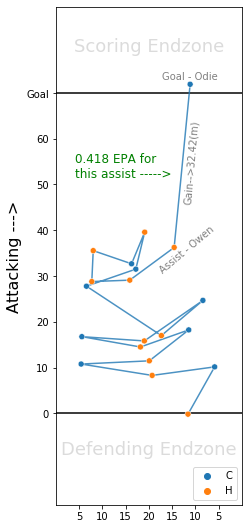

In [1516]:
#epa for each throw in a point
#Longest successful point
fig, ax = plt.subplots(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()
df = df[ (df['Passes'] == df['Passes'].max()) & (df['Point'] == 18)]

x = (df['Start X (0 -> 1 = left sideline -> right sideline)'].append( 
       pd.Series(df['End X (0 -> 1 = left sideline -> right sideline)'].iloc[-1])))
y = 1 - (df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].append( 
     pd.Series(df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].iloc[-1])))
hue = df['Thrower_position'].append(pd.Series(df['Receiver_position'].iloc[-1]))

grid = sns.lineplot(x=x,y=y,alpha=.8,sort=False,ax=ax,zorder=1)
sns.scatterplot(x=x,y=y,alpha=1,hue=hue,hue_order=['C','H'],zorder=2)

#make field
c = 'k'
grid.axvline(x=0,color=c,alpha=0)
grid.axvline(x=1,color=c,alpha=0)
grid.axhline(y=0,color=c,alpha=0)
grid.axhline(y=.1818181818,color=c,zorder=0)
grid.axhline(y=.8181818181,color=c,zorder=0)
grid.axhline(y=.99,color=c,alpha=0)
grid.margins(x=0,y=0)

#set x and yticks as yard markers every 10 yards
xtick = .25/2
ytick = .181818/2
grid.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
grid.set_xticklabels([5,10,15,20,15,10,5])
grid.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
grid.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

grid.set_xlabel('')
grid.set_ylabel('Attacking --->',fontsize=16)

#annotate endzones
grid.text(.50,.9,'Scoring Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)
grid.text(.50,.1,'Defending Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)


#annotate names
goal = df.iloc[-1]
#goal
grid.text(goal['End X (0 -> 1 = left sideline -> right sideline)'],
          (1-goal['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) + .01,
          'Goal - {}'.format(df.iloc[-1]['Receiver'].split(' ')[0]),
          ha='center',color='gray')
#assist
grid.text(goal['Start X (0 -> 1 = left sideline -> right sideline)']+.07,
          (1-goal['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) - .05,
          'Assist - {}'.format(df.iloc[-1]['Thrower'].split(' ')[0]),
          ha='center',rotation=40,color='gray')
#length
grid.text(.73,.6,
          'Gain-->{}(m)'.format(df.iloc[-1]['Forward distance (m)'].round(2)),
          ha='center',rotation=85,color='gray')

grid.text(.1,.65,
          '{} EPA for\nthis assist ----->'.format(round(goal['epa_yat'],3)),
            ha='left',color='green',size='large')

ax.legend(loc='lower right')
plt.show()

Below, I've included a quadrant plot of all the players on the team. The y axis shows the sum of EPA and the x axis charts the mean. The color of the point shows the position of the player (Cutter, Handler). The size of the point shows the total number of throws for that player.<br><br>
You can see that RY (Ruozhou Ye) stands out from the team, accumulating >4 total EPA on .05 EPA per throw. Anecdotaly, most players on the team would say that Ruozhou was our Most Valuable Player, so EPA is doing well so far!<br><br>
**Seaborn** makes it easy to encode variables in multiple ways. The seaborn scatterplot function allowed me to encode position (x,y), hue, and size in one line. The legend plots automatically, without even referring to it in the code. Lastly, the dashed lines on this chart represent the means to the x and y axis, splitting the plot into quadratns with the upper right quadrant generally being "better".

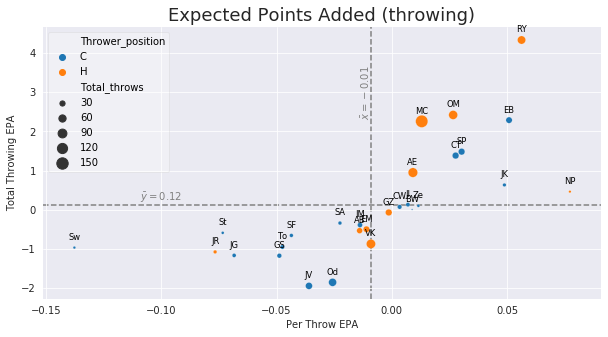

In [1521]:
#groupings of handlers and cutters by average catches
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(10,5))
sns.despine(fig,left=True,bottom=True)

df = full_poss_df.groupby(['Thrower','Thrower_position'])['epa_yat'].agg(['mean','sum','size']).reset_index()
df = (df.merge(player_stats_df[['Player','player_inits']],
               left_on='Thrower',right_on='Player',how='left'))
df.rename(columns={'size':'Total_throws'},inplace=True)

x = 'Thrower'
y1 = 'mean'
y2 = 'sum'


pl = sns.scatterplot(data=df,x=y1,y=y2,hue='Thrower_position',hue_order=['C','H'],size='Total_throws',sizes=(2,150))

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

# ann = (df[ (df[y2] > df[y2].mean()) | (df[y1] > df[y1].mean())]
#        .reset_index(drop=True))
ann = df
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+.2,ann['player_inits'][i],ha='center',size='small')

#annotate dashed lines
pl.text(df[y1].mean()-.002,3,f'$\\bar x = {round(df[y1].mean(),2)}$',
        rotation=90,ha='center',va='center',color='gray')
pl.text(-.1,df[y2].mean()+.18,f'$\\bar y = {round(df[y2].mean(),2)}$',
        rotation=0,ha='center',va='center',color='gray')

ax.set_ylabel('Total Throwing EPA')
ax.set_xlabel('Per Throw EPA')

ax.legend(framealpha=.3)
plt.title('Expected Points Added (throwing)',fontsize=18)
plt.show()

### INDIVIDUAL PLAYER ANALYSIS and POSITION COMPARISONS
Going back to the position distinctions from before, Handlers and Cutters serve very differnt roles on the field. I've included a few visualizations below that show clusters of handlers separated from cutters. Notably, Juleon Robinson is often an outlier here and this makes sense. Juleon used to be a cutter, but also has great handler skills. He served in a "flex" role for us, switching between the two positions more than anyone else on the team, much like a soccer midfielder might have to play defensive or offensive positons depending on the situation.

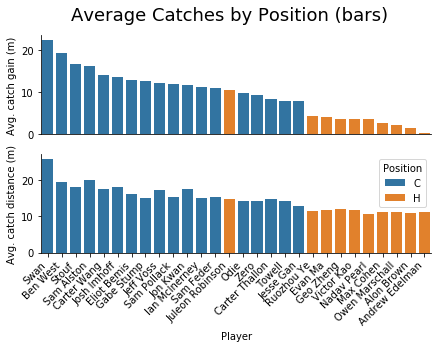

In [1570]:
fig, axs = plt.subplots(2,1,figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'

y1 = 'Average caught pass gain (m)'
y2 = 'Average caught pass distance (m)'

sort = y1

ys = [y1,y2]
for i,y in zip(range(4),ys):
    sns.barplot(data=df.sort_values(by=sort,ascending=False),x=x,y=y,hue='Position',hue_order=['C','H'],
                dodge=False,alpha=1,ax=axs[i])

axs = axs.ravel()
for ax in axs[:1]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('') 
    ax.get_legend().remove() 

axs[0].set_ylabel('Avg. catch gain (m)')
axs[1].set_ylabel('Avg. catch distance (m)')
        
axs[1].set_xticks(range(len(df.sort_values(by=sort,ascending=False).index)))
axs[1].set_xticklabels(df.sort_values(by=sort,ascending=False)['Player'],rotation=45,ha='right')

fig.suptitle('Average Catches by Position (bars)',fontsize=18)
plt.show()

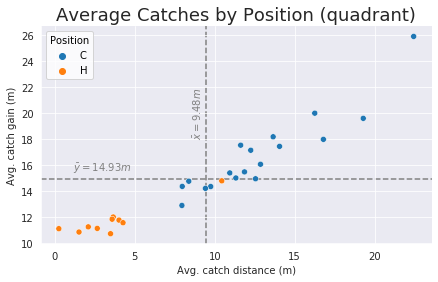

In [1571]:
#groupings of handlers and cutters by average catches
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Average caught pass gain (m)'
y2 = 'Average caught pass distance (m)'

pl = sns.scatterplot(data=df.sort_values(by=y2,ascending=False),x=y1,y=y2,
                     hue='Position',hue_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

# ann = (df[ (df[y2] > df[y2].mean()) & (df[y1] > df[y1].mean())]
#        .reset_index(drop=True))
# for i in range(0,ann.shape[0]):
#     pl.text(ann[y1][i],ann[y2][i]+1,ann['player_inits'][i],ha='center',size='small')
    
#annotate dashed lines
pl.text(df[y1].mean()-.5,20,f'$\\bar x = {round(df[y1].mean(),2)}m$',
        rotation=90,ha='center',va='center',color='gray')
pl.text(3,df[y2].mean()+.8,f'$\\bar y = {round(df[y2].mean(),2)}m$',
        rotation=0,ha='center',va='center',color='gray')

ax.set_ylabel('Avg. catch gain (m)')
ax.set_xlabel('Avg. catch distance (m)')
plt.title('Average Catches by Position (quadrant)',fontsize=18)
plt.show()

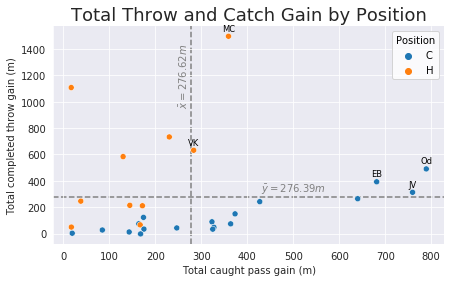

In [1566]:
#grid plot of throwing gain by distance
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7,4))

sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Total caught pass gain (m)'
y2 = 'Total completed throw gain (m)'

pl = sns.scatterplot(data=df.sort_values(by=y2,ascending=False),x=y1,y=y2,
                     hue='Position',hue_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = (df[ (df[y2] > df[y2].mean()) & (df[y1] > df[y1].mean())]
       .reset_index(drop=True))
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+40,ann['player_inits'][i],ha='center',size='small')
    
#annotate dashed lines
pl.text(df[y1].mean()-15,1200,f'$\\bar x = {round(df[y1].mean(),2)}m$',
        rotation=90,ha='center',va='center',color='gray')
pl.text(500,df[y2].mean()+60,f'$\\bar y = {round(df[y2].mean(),2)}m$',
        rotation=0,ha='center',va='center',color='gray')

plt.title('Total Throw and Catch Gain by Position',fontsize=18)
plt.show()

This last quadrant plot touches on a new metric, completion percentage. As I mentioned before, turnovers in ultimate are BAD! So players must be able to complete a high number of their throws. For our team, the average was about 90%. The top right quadrant represents a high completion percentage and a high volume of throws. You can see that it's mostly handlers in this quadrant.

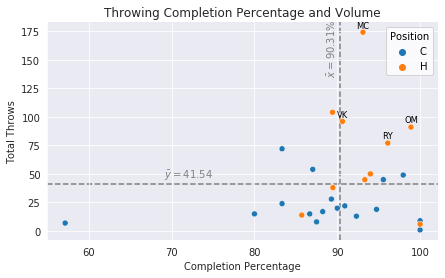

In [1568]:
#compare completion percentage with volume
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()
df['throw_completion_rate'] = ((1 - (df['Thrower errors'] / df['Throws'])) * 100).round(decimals=2)

x = 'Player'
y1 = 'throw_completion_rate'
y2 = 'Throws'

pl = sns.scatterplot(data=df,x=y1,y=y2,
                     hue='Position',hue_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = (df[ (df[y1] > df[y1].mean()) & (df[y2] > df[y2].mean()+10)]
       .reset_index(drop=True))
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+4,ann['player_inits'][i],ha='center',size='small')
    
#annotate dashed lines
pl.text(df[y1].mean()-1,160,f'$\\bar x = {round(df[y1].mean(),2)}$%',
        rotation=90,ha='center',va='center',color='gray')
pl.text(72,df[y2].mean()+7,f'$\\bar y = {round(df[y2].mean(),2)}$',
        rotation=0,ha='center',va='center',color='gray')

ax.set_ylabel('Total Throws')
ax.set_xlabel('Completion Percentage')
plt.title('Throwing Completion Percentage and Volume')
plt.show()

In [ ]:
#groupby and turn combination into list and then sort the list

### COMPLETION PERCENTAGE
Even though our team completion percentage was around 90%, there are a lot of factors that effect that percentage. The most slient factor is "Forward Distance", or distance toward the goal. As you might expect, longer throws are harder to complete.<br><br>
This visualization is an lmplot from seaborn. It's a composite of a scatterplot and a lineplot, but the line is a line of best fit to the data. There are multiple parameters you can tune and it's very easy to plot the confidence interval! The size of each point represents the number of throws in that bin. As you can see, the fit has higher confidence with more data points!

<Figure size 504x288 with 0 Axes>

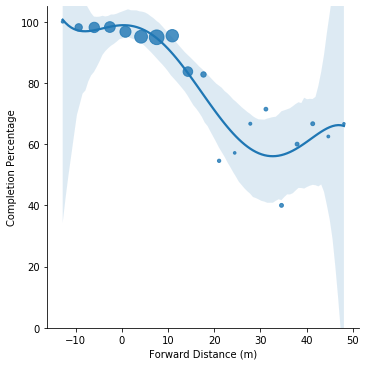

In [1084]:
#compare completion percentage with forward distance thrown
fig= plt.figure(figsize=(7,4))
sns.despine(fig)

#get list of pairs
df = full_poss_df.copy()
errors = (df.groupby(
    pd.cut(df['Forward distance (m)'],
           bins=len(np.arange(-20,70,4))))['Thrower error?'].sum())
total = (df.groupby(
    pd.cut(df['Forward distance (m)'],bins=len(np.arange(-20,70,4))))['Thrower error?'].size())
comps = ((1 - (errors/total)) * 100).round(2).reset_index()
comps['count'] = total.values
comps['dist'] = comps['Forward distance (m)'].apply(lambda x: x.left)
comps['Thrower error?'] = comps['Thrower error?'].fillna(0)

#everyone
line = sns.lmplot(data=comps[:-4],x='dist',y='Thrower error?',order=5,
                  scatter_kws={'s':comps['count']})

line.set(ylim=(0,105),ylabel='Completion Percentage',xlabel='Forward Distance (m)')
plt.show()

### Plotting position on field
To close things out, here is my favorite seabrorn visualization technique, the **jointplot**. jointplot combines a scatter plot with histograms on the x and y axis. This allows the viewer to see how the data is distributed in multiple dimensions.<br><br>
Here I use it to plot the starting location of each throw in our dataset. Again, I've categorized throwers into handlers and cutters and with the jointplot, you can see something really interesting in the x-axis histogram. The distribution for handler throwing positions is almost normal, with a peak in the middle of the field, whereas the cutter distribution is bimodal with the most common throwing locations coming from the sidelines.<br><br>Honestly, this was really surprising to me as conventional Ultimate logic says that the hardest place to throw from is near the sidelines. And our cutters (supposedly our weakest throwers) are making most of their throws from there?!?!<br><br>Hmmmm, next season I'll make sure our cutters get the disc more in the middle of the field. 

In [879]:
def draw_field_sns(endzoney_top=110,endzoney_bot=10):
    grid.fig.set_figwidth(4)
    grid.fig.set_figheight(11)

    c = 'k'
    grid.ax_joint.axvline(x=0,color=c)
    grid.ax_joint.axvline(x=1,color=c)
    grid.ax_joint.axhline(y=0,color=c)
    grid.ax_joint.axhline(y=.1818181818,color=c,zorder=0)
    grid.ax_joint.axhline(y=.8181818181,color=c,zorder=0)
    grid.ax_joint.axhline(y=1,color=c)

    #set x and yticks as yard markers every 10 yards
    xtick = .25/2
    ytick = .181818/2
    grid.ax_joint.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
    grid.ax_joint.set_xticklabels([5,10,15,20,15,10,5])
    grid.ax_joint.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
    grid.ax_joint.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

    grid.ax_joint.set_xlabel('')
    grid.ax_joint.set_ylabel('Attacking --->',fontsize=16)

    #annotate endzones
    grid.ax_joint.text(.50,endzoney_top/120,'Scoring Endzone',
                       ha='center',va='center',
                       color='lightgray',alpha=.8,fontsize=18,zorder=0)
    grid.ax_joint.text(.50,endzoney_bot/120,'Defending Endzone',
                       ha='center',va='center',
                       color='lightgray',alpha=.8,fontsize=18,zorder=0)

<Figure size 240x660 with 0 Axes>

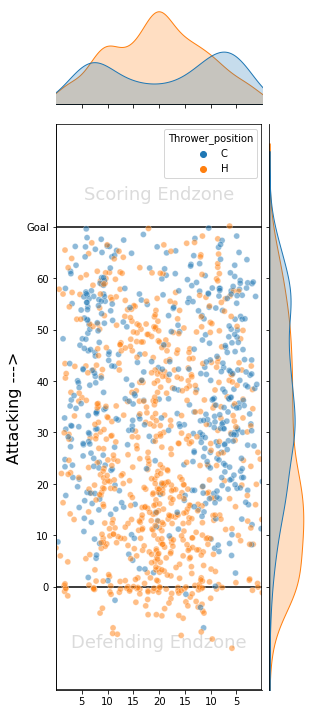

In [1126]:
#All throws
fig = plt.figure(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()

x = df['Start X (0 -> 1 = left sideline -> right sideline)']
y = 1-df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
hue = df['Thrower_position']

grid = sns.jointplot(x=x,y=y,marker='o',alpha=.5,hue=hue,hue_order=['C','H'],
                     xlim=[0,1],ylim=[0,1],marginal_ticks=False)

draw_field_sns(endzoney_top=105)

plt.show()